In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = True
plot_dir = '../plots/plots_2021-01-28'

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
#r_edges = np.logspace(np.log10(1), np.log10(1000), 7) 
#r_edges = np.array([0, 1000])
r_edges = np.array([0, 1])
#r_edges = np.logspace(np.log10(0.01), np.log10(10), 5) 
#r_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
r_units = 'r200'
print(r_edges)

m_order_max = 3
x_order_max = 0 # for scalars, only 0 or 2 x orders

logy = False
unc_tag = '_unc0.1M'
runit_tag = '_r200edges'
y_scalar_feature_name='mass_hydro_subhalo_star'
y_tag = '_msubhalo'

logy_tag = ''
if logy:
    logy_tag = '_logy'
save_tag = f'_xordmax{x_order_max}_mordmax{m_order_max}_rbins{len(r_edges)-1}{logy_tag}{unc_tag}{runit_tag}{y_tag}'

[0 1]


In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer(r_edges, m_order_max, x_order_max, r_units=r_units)
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()

In [5]:
print(featurizer.N_halos)

2344


In [6]:
featurizer.compute_geometric_features()

In [7]:
featurizer.compute_scalar_features()
featurizer.set_y_labels(y_scalar_feature_name='mass_hydro_subhalo_star')

In [8]:
print(featurizer.n_features)

4


In [9]:
uncertainties = 0.1*featurizer.y_scalar # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [10]:
fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                featurizer.x_scalar_dicts, uncertainties=uncertainties)
fitter.split_train_test()
fitter.scale_and_fit(logy=logy)

n_train: 1876, n_test: 468
n_parameters: 4
(4, 4) (4,)
(4,) (4,)
rank: 4
n_feat: 4


In [11]:
fitter.predict()

In [12]:
y_true = fitter.y_scalar_test*mass_multiplier
y_pred = fitter.y_scalar_pred*mass_multiplier
unc_test = fitter.uncertainties_test*mass_multiplier
chi2 = np.mean(((y_pred - y_true)/unc_test)**2)
print(f"chi^2 = {chi2:.3e}")

chi^2 = 5.201e+01


In [13]:
print("In training set:")
print(f"Total number of halos: {fitter.n_train}")
print(f"Number of zero-stellar-mass halos: {fitter.n_train - np.count_nonzero(fitter.y_scalar_train)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_train)*mass_multiplier:.3e} / {max(fitter.y_scalar_train)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_train[np.nonzero(fitter.y_scalar_train)[0]])*mass_multiplier:.3e}")

In training set:
Total number of halos: 1876
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 4.349e+06 / 9.169e+11
Minimum nonzero mass: 4.349e+06


In [14]:
print("In test set:")
print(f"Total number of halos: {fitter.n_test}")
print(f"Number of zero-stellar-mass halos: {fitter.n_test - np.count_nonzero(fitter.y_scalar_test)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_test)*mass_multiplier:.3e} / {max(fitter.y_scalar_test)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_test[np.nonzero(fitter.y_scalar_test)[0]])*mass_multiplier:.3e}")
print()
print(f"Minimum nonzero predicted mass: {min(fitter.y_scalar_pred[np.nonzero(fitter.y_scalar_pred)[0]])*mass_multiplier:.3e}")
print(f"Minimum positive predicted mass: {min(fitter.y_scalar_pred[np.where(fitter.y_scalar_pred > 0)[0]])*mass_multiplier:.3e}")
print(f"Number mass predictions with m<0:", len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0]))
print(f"Number mass predictions with |m|<1e5:", len(np.where(abs(fitter.y_scalar_pred*mass_multiplier) < 1e5)[0]))

In test set:
Total number of halos: 468
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 6.473e+06 / 6.675e+10
Minimum nonzero mass: 6.473e+06

Minimum nonzero predicted mass: 1.358e+07
Minimum positive predicted mass: 1.358e+07
Number mass predictions with m<0: 0
Number mass predictions with |m|<1e5: 0


In [15]:
featurizer.x_scalar_features.shape
print(featurizer.y_scalar.shape)
print(np.min(featurizer.y_scalar), np.max(featurizer.y_scalar))
print(np.min(featurizer.x_scalar_features[:,1]), np.max(featurizer.x_scalar_features[:,1]))

(2344,)
0.0004349329392425716 91.685302734375
0.0 13203.328601978441


(100000000.0, 100000000000000.0)

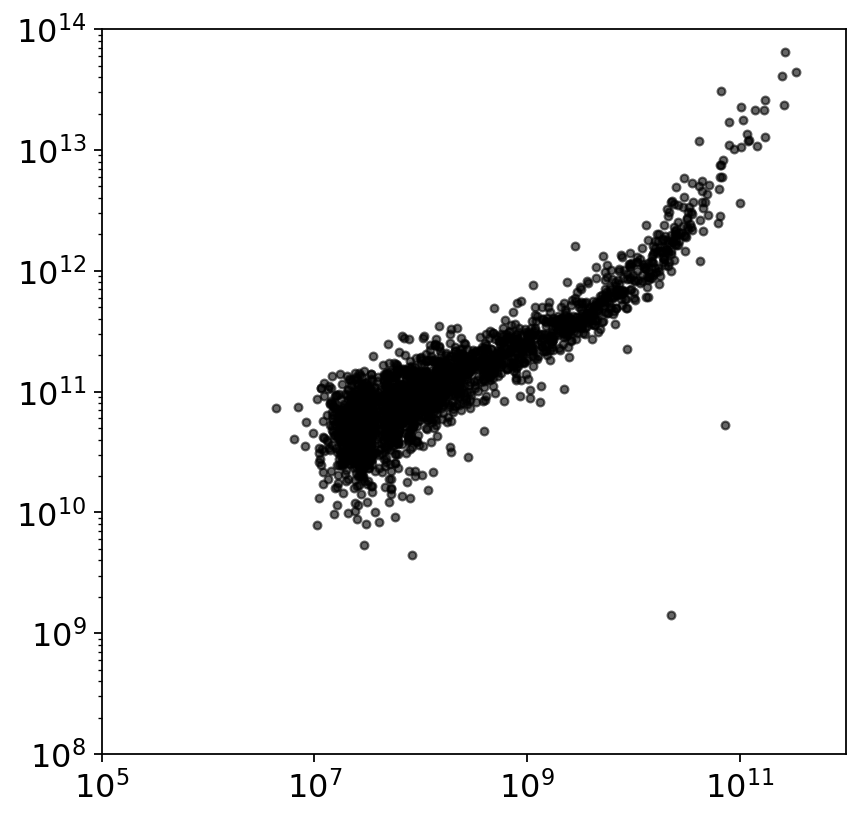

In [16]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
  
# main scatter plotting
plt.scatter(featurizer.y_scalar*mass_multiplier, featurizer.x_scalar_features[:,1]*mass_multiplier, s=12, alpha=0.6, c='k')
plt.xscale('log')
plt.yscale('log')
#ax.set_aspect('equal')

plt.xlim(1e5, 1e12)
plt.ylim(1e8, 1e14)

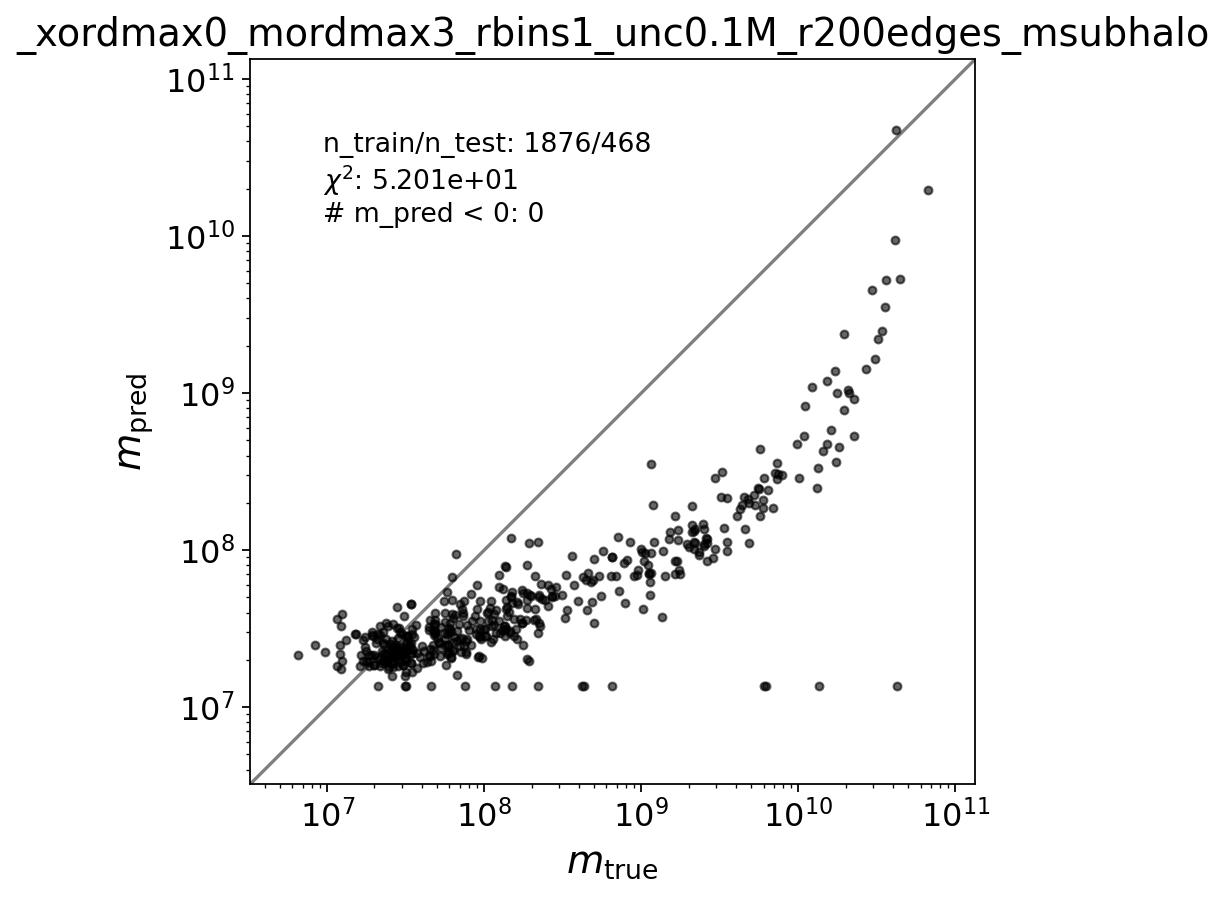

In [22]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
  
# main scatter plotting
plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k')

# get limits, plot true line
m_minmin = min(min(y_true[np.where(y_true > 0)]), 
               min(y_pred[np.where(y_pred > 0)]))
m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
               max(y_pred[np.where(y_true > 0)]))
true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
plt.plot(true_line, true_line, color='grey', zorder=0)

# labels & adjustments
plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel(r'$m_\mathrm{pred}$')
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlim(0.5*m_minmin, 2*m_maxmax)
plt.ylim(0.5*m_minmin, 2*m_maxmax)

n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
plt.text(0.1, 0.9, fr'n_train/n_test: {fitter.n_train}/{fitter.n_test}' '\n'
                   fr'$\chi^2$: {chi2:.3e}' '\n'
                   fr'# m_pred < 0: {n_neg}', 
         transform=ax.transAxes, verticalalignment='top', fontsize=12)
plt.title(save_tag)

# save
save_fn = f'mass_recovery{save_tag}.pdf'
if save_plots:
      plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

(array([232., 109.,  71.,  25.,  20.,   3.,   2.,   1.,   2.,   3.]),
 array([-0.99968071, -0.67036125, -0.3410418 , -0.01172234,  0.31759711,
         0.64691657,  0.97623603,  1.30555548,  1.63487494,  1.96419439,
         2.29351385]),
 [<matplotlib.patches.Polygon at 0x14bab2083160>])

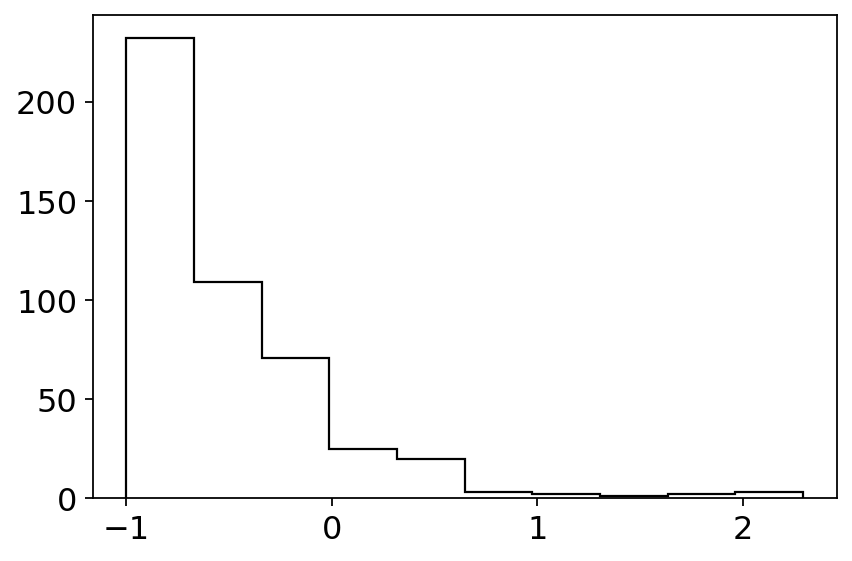

In [18]:
plt.hist((y_pred - y_true)/y_true, histtype='step', color='k')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 468.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-100.        ,  -89.47368421,  -78.94736842,  -68.42105263,
         -57.89473684,  -47.36842105,  -36.84210526,  -26.31578947,
         -15.78947368,   -5.26315789,    5.26315789,   15.78947368,
          26.31578947,   36.84210526,   47.36842105,   57.89473684,
          68.42105263,   78.94736842,   89.47368421,  100.        ]),
 [<matplotlib.patches.Polygon at 0x14bab2036760>])

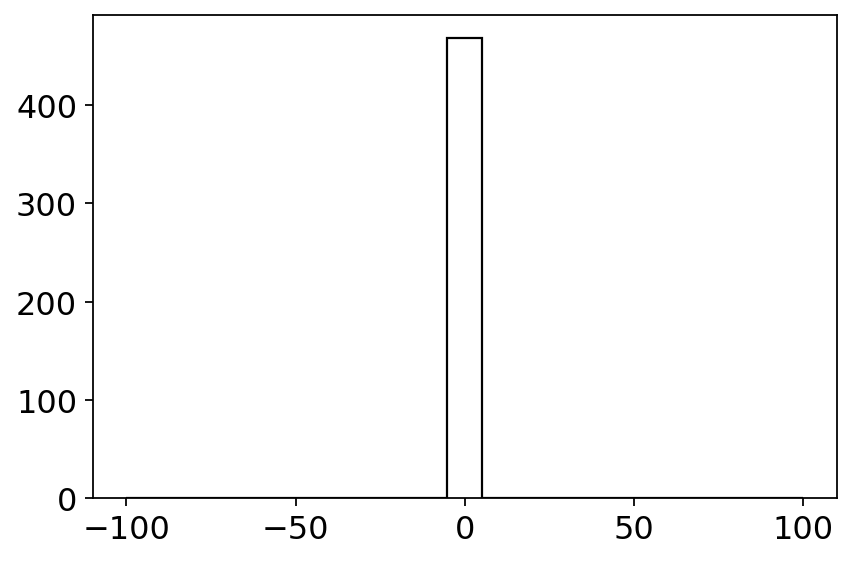

In [19]:
bins = np.linspace(-100, 100, 20)
plt.hist((y_pred - y_true)/y_true, bins=bins, histtype='step', color='k')

(array([  2.,   1.,   3.,   3.,   4.,   8.,   8.,  21., 417.,   1.]),
 array([-4.72441602e+10, -4.19753091e+10, -3.67064580e+10, -3.14376069e+10,
        -2.61687559e+10, -2.08999048e+10, -1.56310537e+10, -1.03622026e+10,
        -5.09335154e+09,  1.75499537e+08,  5.44435062e+09]),
 [<matplotlib.patches.Polygon at 0x14bab209d4f0>])

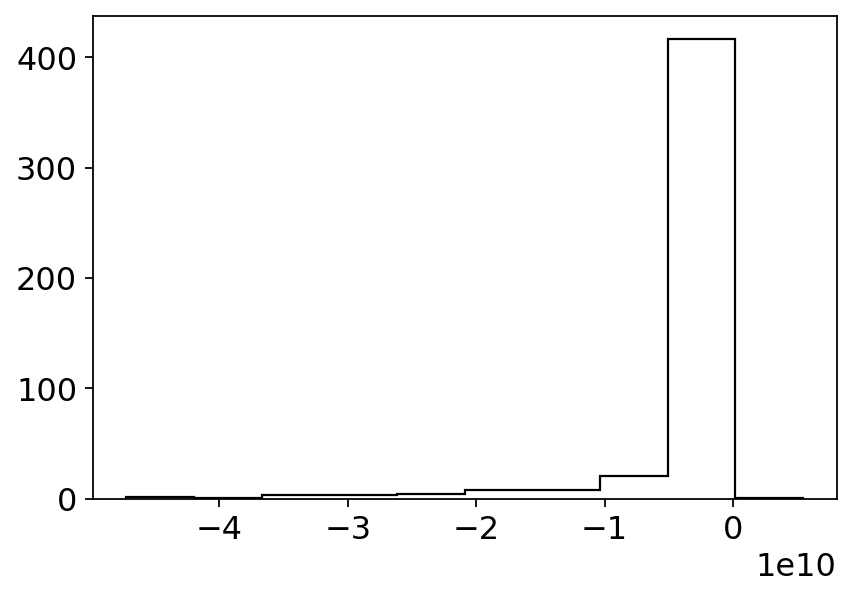

In [20]:
plt.hist((y_pred - y_true), histtype='step', color='k')